# Initialize the environment

In [4]:
!pip install -Uqq fastai duckduckgo_search

# Search and download images

## Define the search function

In [8]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

## Download the images

In [9]:
urls = search_images('panda photos', max_images=1)
urls[0]

Searching for 'panda photos'


/opt/homebrew/anaconda3/lib/python3.11/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/homebrew/anaconda3/lib/python3.11/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/homebrew/anaconda3/lib/python3.11/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://www.wallpaperup.com/uploads/wallpapers/2014/06/05/364485/7a7bab94251a5afd39ea35b3611a2e2e.jpg'

## Download and save the first picture

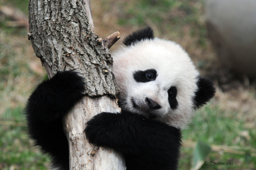

In [11]:
from fastdownload import download_url
dest = './tmp/panda.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

## Download images with another category 

Searching for 'bear photos'


/opt/homebrew/anaconda3/lib/python3.11/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/homebrew/anaconda3/lib/python3.11/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/homebrew/anaconda3/lib/python3.11/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


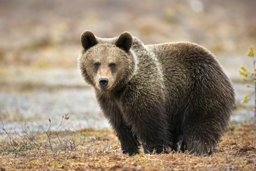

In [12]:
download_url(search_images('bear photos', max_images=1)[0], 'tmp/bear.jpg', show_progress=False)
Image.open('tmp/bear.jpg').to_thumb(256,256)

## Download image set

In [13]:
searches = 'panda','bear'
path = Path('tmp/panda_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'panda photo'
Searching for 'panda photo'
Searching for 'bear photo'
Searching for 'bear photo'


## Remove broken images

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

# Train the model

## Create data block

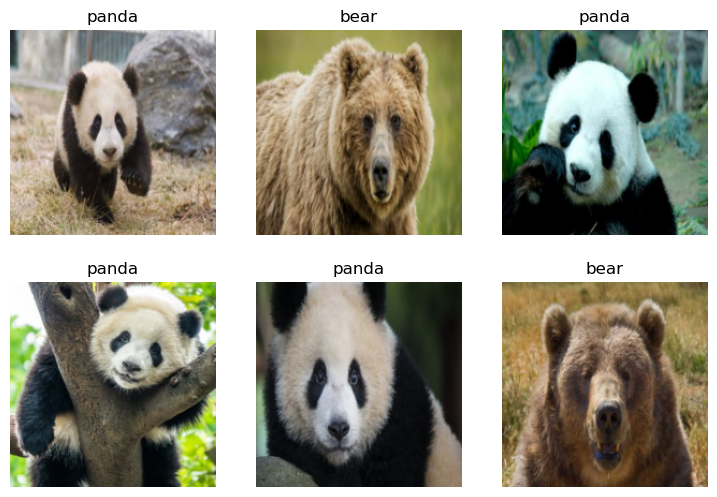

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## Train

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/klniu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7

epoch,train_loss,valid_loss,error_rate,time
0,1.155962,0.919045,0.318182,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.276866,0.072443,0.000000,00:00
1,0.153791,0.009087,0.000000,00:00
2,0.107370,0.003944,0.000000,00:00


## Verification

### Panda

In [28]:
is_panda,_,probs = learn.predict(PILImage.create('tmp/panda.jpg'))
print(f"This is a: {is_panda}.")
print(f"Probability it's a panda: {probs[0]:.4f}")

This is a: panda.
Probability it's a panda: 0.0000


## Bear

In [27]:
is_bear,_,probs = learn.predict(PILImage.create('tmp/bear.jpg'))
print(f"This is a: {is_bear}.")
print(f"Probability it's a bear: {probs[0]:.4f}")

This is a: bear.
Probability it's a bear: 0.9999
